In [1]:
import json
import numpy as np
import pandas as pd
from superlink.superlink import SuperLink
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
sns.set_palette('husl')
%matplotlib inline

In [2]:
with open('../data/six_pipes.json', 'r') as j:
    inp = json.load(j)
    
superjunctions = pd.DataFrame(inp['superjunctions'])
superlinks = pd.DataFrame(inp['superlinks'])
junctions = pd.DataFrame(inp['junctions'])
links = pd.DataFrame(inp['links'])

In [3]:
H_bc = pd.read_csv('../data/boundary_stage.csv', index_col=0)
Q_in = pd.read_csv('../data/flow_input.csv', index_col=0)
t_range = H_bc.index.values

In [4]:
superlink = SuperLink(superlinks, superjunctions, links, junctions)

# Simulation with additive Gaussian noise

In [5]:
# Create lists to store results
hs = []
Hs = []
Qs = []
ts = []
Q_ins = []
H_bcs = []

# Set initial time
t_prev = t_range[0]

# For each time step...
for t_next in t_range[1:]:
    # Compute time difference between steps
    dt = t_next - t_prev
    # Get next stage boundary condition
    H_bc_next = H_bc.loc[t_next].values
    # Get net flow input
    Q_in_next = Q_in.loc[t_next].values
    Q_in_next_c = Q_in_next + 0.05*np.random.randn(Q_in_next.size)
    # Run superlink algorithm
    superlink.step(H_bc=H_bc_next, Q_in=Q_in_next_c, dt=dt)
    # Store previous timestamp
    t_prev = t_next
    # Store results
    ts.append(t_next)
    hs.append(np.copy(superlink._h_Ik))
    Hs.append(superlink.H_j)
    Qs.append((superlink._Q_uk + superlink._Q_dk) / 2)
    Q_ins.append(Q_in_next_c)
    H_bcs.append(H_bc_next)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [6]:
Qs = np.vstack(Qs)
Hs = np.vstack(Hs)
Q_ins = np.vstack(Q_ins)
H_bcs = np.vstack(H_bcs)
ts = np.asarray(ts)

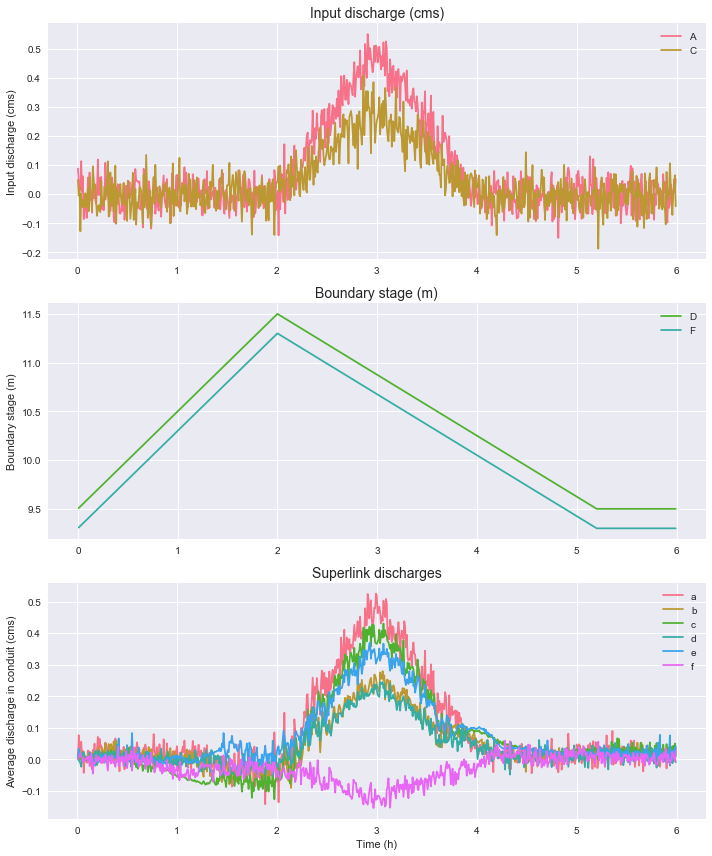

In [7]:
fig, ax = plt.subplots(3, figsize=(10, 12))
ax[0].plot(ts / 3600, Q_ins[:,0], label='A')
ax[0].plot(ts / 3600, Q_ins[:,2], label='C')
ax[0].set_title('Input discharge (cms)', size=14)
ax[0].set_ylabel('Input discharge (cms)')
ax[0].legend()
ax[1].plot([0], [10])
ax[1].plot([0], [10])
ax[1].plot(ts / 3600, Hs[:,3], label='D')
ax[1].plot(ts / 3600, Hs[:,5], label='F')
ax[1].set_title('Boundary stage (m)', size=14)
ax[1].set_ylabel('Boundary stage (m)')
ax[1].legend()
ax[2].plot(ts / 3600, Qs[:,0], label='a')
ax[2].plot(ts / 3600, Qs[:,1], label='b')
ax[2].plot(ts / 3600, Qs[:,2], label='c')
ax[2].plot(ts / 3600, Qs[:,3], label='d')
ax[2].plot(ts / 3600, Qs[:,4], label='e')
ax[2].plot(ts / 3600, Qs[:,5], label='f')
ax[2].set_title('Superlink discharges', size=14)
ax[2].set_xlabel('Time (h)')
ax[2].set_ylabel('Average discharge in conduit (cms)')
ax[2].legend()
plt.tight_layout()

# Use a "clean" simulation as observations

In [8]:
superlink = SuperLink(superlinks, superjunctions, links, junctions)    

In [9]:
# Create lists to store results
hs = []
Hs = []
Qs = []
ts = []
Q_ins = []
H_bcs = []

# Set initial time
t_prev = t_range[0]

# For each time step...
for t_next in t_range[1:]:
    # Compute time difference between steps
    dt = t_next - t_prev
    # Get next stage boundary condition
    H_bc_next = H_bc.loc[t_next].values
    # Get net flow input
    Q_in_next = Q_in.loc[t_next].values
    # Run superlink algorithm
    superlink.step(H_bc=H_bc_next, Q_in=Q_in_next, dt=dt)
    # Store previous timestamp
    t_prev = t_next
    # Store results
    ts.append(t_next)
    hs.append(np.copy(superlink._h_Ik))
    Hs.append(superlink.H_j)
    Qs.append((superlink._Q_uk + superlink._Q_dk) / 2)
    Q_ins.append(Q_in_next)
    H_bcs.append(H_bc_next)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [10]:
Z = np.vstack(Hs)

# Apply implicit Kalman filter

In [11]:
np.random.seed(0)

In [12]:
superlink = SuperLink(superlinks, superjunctions, links, junctions)    

In [13]:
M = superlink.M
H = np.eye(M)
Qcov = (0.05**2)*np.eye(M)
Rcov = (0.01**2)*np.eye(M)
C = np.eye(M)
P = C @ Qcov @ C.T
I = np.eye(M)
bc = superlink.bc.astype(bool)

P_k_k = P

In [14]:
# Create lists to store results
hs = []
Hs = []
Qs = []
ts = []
Q_ins = []
H_bcs = []

# Set initial time
t_prev = t_range[0]

# For each time step...
for i, t_next in enumerate(t_range[1:]):
    # Compute time difference between steps
    dt = t_next - t_prev
    # Get next stage boundary condition
    H_bc_next = H_bc.loc[t_next].values
    # Get net flow input
    Q_in_next = Q_in.loc[t_next].values
    Q_in_next_c = Q_in_next + 0.05*np.random.randn(Q_in_next.size)
    # Run superlink algorithm
    superlink.link_hydraulic_geometry()
    superlink.compute_storage_areas()
    superlink.node_velocities()
    superlink.link_coeffs(_dt=dt)
    superlink.node_coeffs(_dt=dt)
    superlink.forward_recurrence()
    superlink.backward_recurrence()
    superlink.superlink_upstream_head_coefficients()
    superlink.superlink_downstream_head_coefficients()
    superlink.superlink_flow_coefficients()
    superlink.sparse_matrix_equations(H_bc=H_bc_next, _Q_0j=Q_in_next_c,
                                      first_time=False, _dt=dt)
    superlink.solve_sparse_matrix()
    # Start filtering
    b = superlink.b
    A_1 = superlink.A.tocsc()
    A_2 = np.diag(np.where(~bc, superlink._A_sj / dt, 0))
    y_k1_k = b
    H_1 = H @ scipy.sparse.linalg.inv(A_1)
    P_k1_k = A_2 @ P_k_k @ A_2.T + C @ Qcov @ C.T
    L_k1 = P_k1_k @ H_1.T @ np.linalg.inv(H_1 @ P_k1_k @ H_1.T + Rcov)
    P_k1_k1 = (I - L_k1 @ H_1) @ P_k1_k
    b_hat = y_k1_k + L_k1 @ (Z[i] - H_1 @ y_k1_k)
    superlink.b = b_hat
    superlink.solve_sparse_matrix()
    superlink.solve_superlink_flows()
    superlink.solve_superlink_depths_alt()
    superlink.solve_internals_lsq()
    P_k_k = P_k1_k1
    # Store previous timestamp
    t_prev = t_next
    # Store results
    ts.append(t_next)
    hs.append(np.copy(superlink._h_Ik))
    Hs.append(superlink.H_j)
    Qs.append((superlink._Q_uk + superlink._Q_dk) / 2)
    Q_ins.append(Q_in_next_c)
    H_bcs.append(H_bc_next)

/Users/mdbartos/Git/superlink/superlink/geometry.py:55: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(1 - y / r)


In [15]:
Qs = np.vstack(Qs)
Hs = np.vstack(Hs)
Q_ins = np.vstack(Q_ins)
H_bcs = np.vstack(H_bcs)
ts = np.asarray(ts)

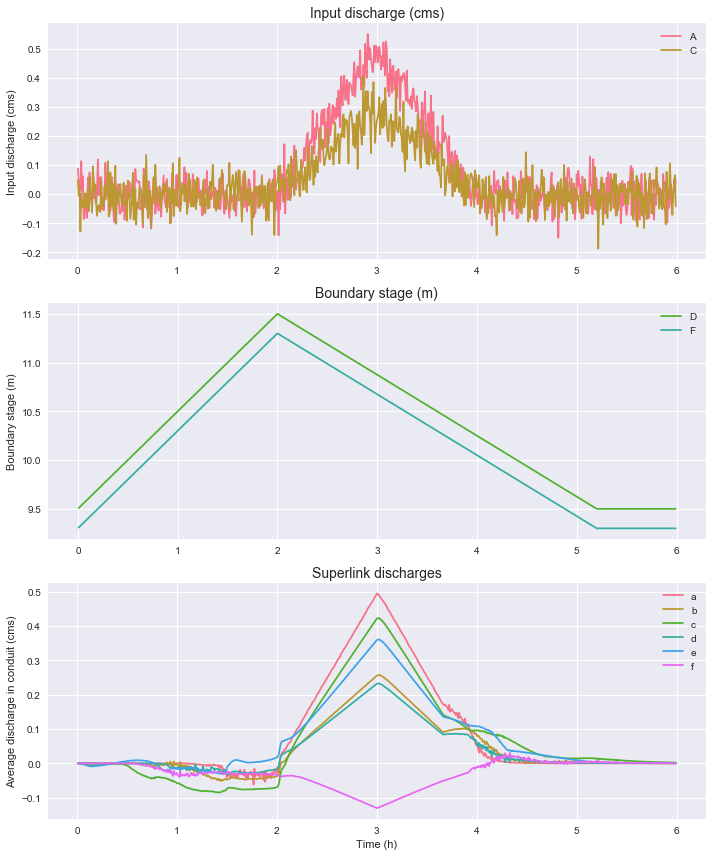

In [16]:
fig, ax = plt.subplots(3, figsize=(10, 12))
ax[0].plot(ts / 3600, Q_ins[:,0], label='A')
ax[0].plot(ts / 3600, Q_ins[:,2], label='C')
ax[0].set_title('Input discharge (cms)', size=14)
ax[0].set_ylabel('Input discharge (cms)')
ax[0].legend()
ax[1].plot([0], [10])
ax[1].plot([0], [10])
ax[1].plot(ts / 3600, Hs[:,3], label='D')
ax[1].plot(ts / 3600, Hs[:,5], label='F')
ax[1].set_title('Boundary stage (m)', size=14)
ax[1].set_ylabel('Boundary stage (m)')
ax[1].legend()
ax[2].plot(ts / 3600, Qs[:,0], label='a')
ax[2].plot(ts / 3600, Qs[:,1], label='b')
ax[2].plot(ts / 3600, Qs[:,2], label='c')
ax[2].plot(ts / 3600, Qs[:,3], label='d')
ax[2].plot(ts / 3600, Qs[:,4], label='e')
ax[2].plot(ts / 3600, Qs[:,5], label='f')
ax[2].set_title('Superlink discharges', size=14)
ax[2].set_xlabel('Time (h)')
ax[2].set_ylabel('Average discharge in conduit (cms)')
ax[2].legend()
plt.tight_layout()